# Relaxation time Calculations

In [127]:
!pip install PyIF nose numba seaborn

  Using cached PyIF-0.1-py3-none-any.whl (7.1 kB)
  Using cached nose-1.3.7-py3-none-any.whl (154 kB)
  Using cached numba-0.56.4.tar.gz (2.4 MB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [8 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "/tmp/pip-install-9zvua4ro/numba_90388fabc453471eafca8fbad1651f6d/setup.py", line 51, in <module>
          _guard_py_ver()
        File "/tmp/pip-install-9zvua4ro/numba_90388fabc453471eafca8fbad1651f6d/setup.py", line 48, in _guard_py_ver
          raise RuntimeError(msg.format(cur_py, min_py, max_py))
      RuntimeError: Cannot install on Python version 3.11.0; only versions >=3.7,<3.11 are supported.
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with

In [6]:
!conda install -y -c conda-forge seaborn

- 

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess
import shutil
from nilearn import datasets
from nilearn.image import load_img, index_img
from nilearn.plotting import plot_epi
from nilearn.maskers import NiftiLabelsMasker
# from PyIF import te_compute as te
from joblib import delayed, Parallel
# import seaborn as sns

In [18]:
# fp = '/home/shivansh.seth/phase_diagram_analysis/data/input_data/abide/nyu_power/51074.txt'
# fp = '/scratch/shivansh.seth/adni/output/preproc/sub-019_S_5012/fwhm-5_sfunc.nii'
root_dir = '/scratch/shivansh.seth/adni/output/preproc'
z_root_dir = '/home/shivansh.seth/adni/parcellated_z_output'
OUTPUT_DIR = '/home/shivansh.seth/adni/parcellated_z_subjects_output'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

## Dataloaders

In [19]:
class DataLoader:
    def __init__(self, root_dir, subjects_list=False):
        '''
        Note that `root_dir` should only contain folders with subject names and should
        follow the structure `root_dir/<subject_dir_prefix+subject_name/modality_filename`
        '''
        
        self.func_name = 'fwhm-5_sfunc.nii'
        self.anat_name = 'anat_brain.nii.gz'
        self.subject_dir_prefix = 'sub-'
        
        self.z_region_suffix = '_z_timeseries.txt'
        
        self.cn_names_fp = '/home/shivansh.seth/adni/cn_subject_names.txt'
        self.ad_names_fp = '/home/shivansh.seth/adni/ad_subject_names.txt'
        self.cn_subs = [ i.strip() for i in open(self.cn_names_fp).readlines() ]
        self.ad_subs =[ i.strip() for i in open(self.ad_names_fp).readlines() ]
        
        self.root_dir = root_dir
        self.subject_dirs_list = os.listdir(root_dir)
        if (type(subjects_list) == type(False)) and (subjects_list == False):
            self.subjects_list = self._get_subjects_list()
        else:
            self.subjects_list = subjects_list
        
        self.diag = []
        for sub in subjects_list:
            self.diag.append(1 if sub in self.ad_subs else 0)
            
        return
    
    def _get_subjects_list(self):
        subs = []
        for i in self.subject_dirs_list:
            subs.append(i.replace(self.subject_dir_prefix, ''))
        return subs
    
    def get_func(self, subject_name, get_image=True):
        fp = self.get_nii_fp(subject_name, self.func_name)
        
#         print(f"Retrieving from {fp}")
        img = load_img(fp)
        data = img.get_fdata()
        if get_image:
            return img
        return data
    
    def get_anat(self, subject_name, get_image=True):
        fp = self.get_nii_fp(subject_name, self.anat_name)
        img = load_img(fp)
        data = img.get_fdata()
        if get_image:
            return img
        return data
    
    def get_nii_fp(self, subject_name, modal_name):
        fp = os.path.join(self.root_dir, self.subject_dir_prefix + str(subject_name), modal_name)
        if type(subject_name) == int:
            fp = os.path.join(self.root_dir, self.subject_dirs_list[subject_name], modal_name)
        return fp
    
    def get_z_region_output(self, subject_name):
        fp = os.path.join(self.root_dir, str(subject_name) + self.z_region_suffix)
        if type(subject_name) == int:
            fp = os.path.join(self.root_dir, self.subjects_list[subject_name] + self.z_region_suffix)
        ts = np.loadtxt(fp)
        return ts
    
    pass

In [20]:
class Parcellator:
    def __init__(self, dloader):
        aal = datasets.fetch_atlas_aal()
        self.atlas_filename = aal.maps
        self.labels = aal.labels
        self.dloader = dloader
        return
    
    def parcellate(self, img, return_labels=False):
        masker = NiftiLabelsMasker(labels_img=self.atlas_filename)
        parcellated_data = masker.fit_transform(img)

        if return_labels:
            return parcellated_data, self.labels
        return parcellated_data
    
    def parcellate_all_func_subjects(self, save=False):
        if not os.path.exists(OUTPUT_DIR):
            os.makedirs(OUTPUT_DIR)
        fps = []
        for sub in self.dloader.subjects_list:
            img = self.dloader.get_func(sub)
            parc_img = self.parcellate(img)
            save_fp = os.path.join(OUTPUT_DIR, f"{sub}_timeseries.txt")
            np.savetxt(save_fp, parc_img)
            fps.append(save_fp)
            print(f"Saved {sub} to {save_fp}")
        return fps

In [21]:
class GlobalSignal:

    @staticmethod
    def get_gs_gstd(parc_img):
        gs = np.mean(parc_img, axis=1)
        gstd = np.std(parc_img, axis=1)
        return gs, gstd

    @staticmethod
    def get_sub_gs_img(parc_img, gs):
        sub_gs_img = []
        for i in range(parc_img.shape[1]):
            sub_gs_img.append(parc_img[:, i] - gs)
        sub_gs_img = np.array(sub_gs_img).T
        return sub_gs_img

    @staticmethod
    def get_z_img(parc_img, gs, gstd):
        z_img = []
        for i in range(parc_img.shape[1]):
            z_img.append( ( parc_img[:, i] - gs ) / gstd )
        z_img = np.array(z_img).T
        return z_img
    
    pass


In [23]:
dloader = DataLoader(root_dir)
# parcellator = Parcellator(dloader)

FileNotFoundError: [Errno 2] No such file or directory: '/scratch/shivansh.seth/adni/output/preproc'

In [7]:
def z_score_all_subjects(dloader, parcellator, save=False):
    
    for i in range(len(dloader.subjects_list)):
        subject = dloader.subjects_list[i]
        print(f"{i}: Running subject {subject}")
        
        img = dloader.get_func(subject)
        parc_img = parcellator.parcellate(img)
        gs, gstd = GlobalSignal.get_gs_gstd(parc_img)
        
#         print(f"parc_img: {parc_img.shape}, gs: {gs.shape}, gstd: {gstd.shape}")

        sub_gs_img = GlobalSignal.get_sub_gs_img(parc_img, gs)
        z_img = GlobalSignal.get_z_img(parc_img, gs, gstd)
        
#         print(f"sub_gs_img: {sub_gs_img.shape}, z_img: {z_img.shape}")

        if save:
            np.savetxt(os.path.join(OUTPUT_DIR, f"{subject}_z_timeseries.txt"), z_img)
            np.savetxt(os.path.join(OUTPUT_DIR, f"{subject}_sub_gs_timeseries.txt"), sub_gs_img)
            np.savetxt(os.path.join(OUTPUT_DIR, f"{subject}_gs.txt"), gs)
            np.savetxt(os.path.join(OUTPUT_DIR, f"{subject}_gstd.txt"), gstd)
        
        print(f"{i}: Finished subject {subject} \n")
    return
    

In [8]:
# z_score_all_subjects(dloader, parcellator, save=False)

#### Testing for random subject

In [276]:
img = dloader.get_func("136_S_0186")
img.shape

(51, 67, 67, 200)

In [277]:
parc_img = parcellator.parcellate(img)
parc_img.shape

(200, 116)

In [278]:
gs, gstd = GlobalSignal.get_gs_gstd(parc_img)
gs.shape, gstd.shape

((200,), (200,))

In [280]:
subs_gs_img = GlobalSignal.get_sub_gs_img(parc_img, gs)
z_img = GlobalSignal.get_z_img(parc_img, gs, gstd)
sub_gs_img.shape, z_img.shape, parc_img.shape

((140, 116), (200, 116), (200, 116))

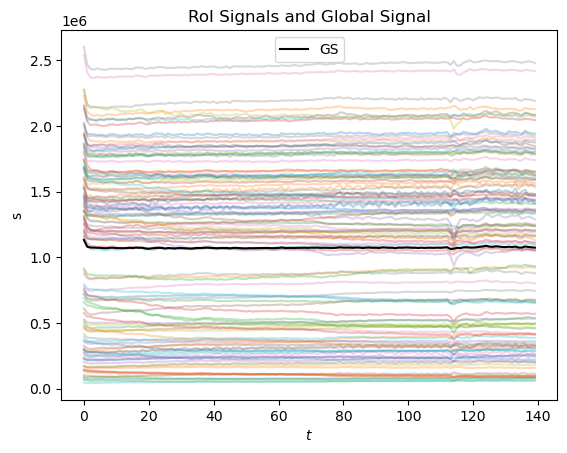

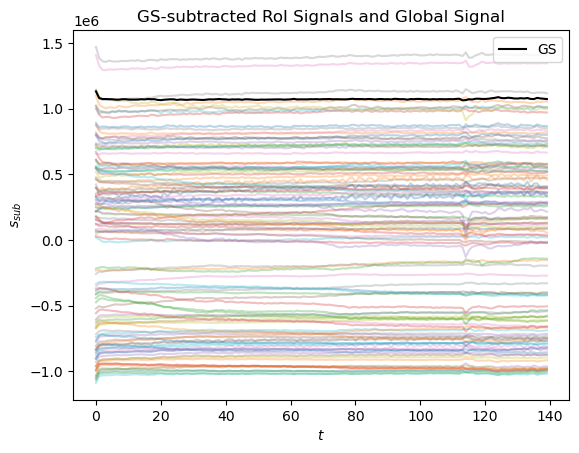

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


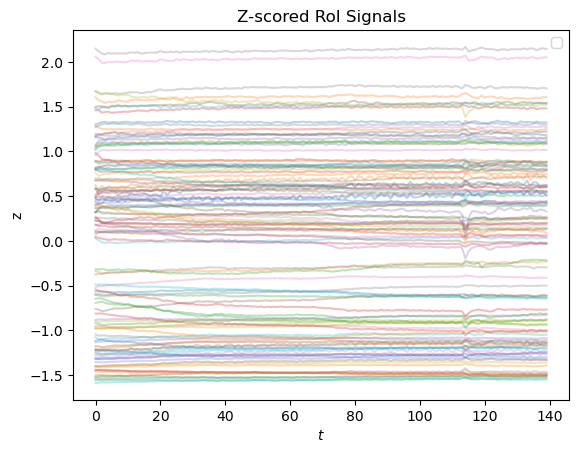

In [247]:
# Visualising signal transformation

for i in range(parc_img.shape[1]):
    plt.plot(range(len(parc_img[:, i])), parc_img[:, i], alpha=0.3, linestyle='-')
plt.plot(range(len(gs)), gs, color='black', label='GS')
plt.title("RoI Signals and Global Signal")
plt.xlabel("$t$")
plt.ylabel("s")
plt.legend()
plt.show()

for i in range(parc_img.shape[1]):
    plt.plot(range(len(sub_gs_img[:, i])), sub_gs_img[:, i], alpha=0.3, linestyle='-')
plt.plot(range(len(gs)), gs, color='black', label='GS')
plt.title("GS-subtracted RoI Signals and Global Signal")
plt.xlabel("$t$")
plt.ylabel("$s_{sub}$")
plt.legend()
plt.show()

for i in range(parc_img.shape[1]):
    plt.plot(range(len(z_img[:, i])), z_img[:, i], alpha=0.3)
# plt.plot(range(len(gs)), gs, label='GS')
plt.title("Z-scored RoI Signals")
plt.xlabel("$t$")
plt.ylabel("z")
plt.legend()
plt.show()

- The global max value of the z-scored signals is considered the upspin and the min the downspin. The binarization is done according to this.
- We remove field because it seems to be redundant and apparently has no effect in the phase space
- Check if it is possible to compare the absolute signals between two regions from fMRI or if the different mean signals are just an artifact of the local gradients from scanning. Also check if this can be negated in any way

$$
\\eps_i = c_{OL}.S_i + h_i S_i
\\eps_i = \sigma \eps (e^{-f(e)}/\sigma \eps^{-f(e)})
$$

## Relaxation Times

In [ ]:
from scipy.stats import zscore

In [75]:
# def autocorr(x):
#     xp = x - np.mean(x)
#     n = len(x)
#     f = np.fft.fft(xp, n*2)
#     acf = np.real(np.fft.ifft(f * np.conjugate(f))[:n])
#     acf /= (4*np.var(x))
#     acf /= acf[0]
#     return acf

# def relaxation_time(x, tau_max=None, threshold=np.exp(-1)):
#     acf = autocorr(x)
#     if tau_max is None:
#         tau_max = len(x) // 10
#     idx = np.where(acf < threshold)[0]
#     if len(idx) == 0:
#         tau = tau_max
#     else:
#         tau = idx[0]
#     return tau

In [26]:
subjects_list = list(set( [ '_'.join(i.split("_")[:3]) for i in os.listdir(z_root_dir) ]))
# subjects_list

In [27]:
dloader = DataLoader(z_root_dir, subjects_list=subjects_list)

In [28]:
ts_data = []
trunc_lim = 140
n_rois = 116
for sub in subjects_list:
    ts = dloader.get_z_region_output(sub)
    
    ts_data.append(ts[:trunc_lim])
ts_data = np.array(ts_data)
ts_data.shape

(88, 140, 116)

In [13]:
# Quality check
for ind in range(len(ts_data)):
    i = ts_data[ind]
    if i.shape != (140, 116):
        print(i.shape)
        print(dloader.subjects_list[ind])

In [108]:
def autocorr(x):
    xp = x - np.mean(x)
    n = len(x)
    f = np.fft.fft(xp, n*2)
    acf = np.real(np.fft.ifft(f * np.conjugate(f))[:n])
    # acf /= (4*np.var(x))
    acf /= acf[0]
    return acf

from scipy.optimize import curve_fit

def exp_decay(t, tau, A, B=0):
    return A * np.exp(-t/tau) + B

def relaxation_time(x, t, t_max=None):
    if t_max is None:
        t_max = len(t) // 5
    p0 = [t[t_max], ]
    B = np.mean(x[50:])
    A = 1 - B
    func = lambda t, tau: exp_decay(t, tau, A=A, B=B)
    popt, pcov = curve_fit(func, t[:t_max], x[:t_max], p0=p0)
    se = np.sqrt(np.mean(np.diag(pcov)))
    t = np.array(t)
#     print(t.shape)
    res = x - func(t, *popt)
    rmse = np.sqrt(np.mean(res**2))
    print
    tau = popt[0]
    return tau, A, B, rmse, se

In [106]:
def plot_w_fit(data, tau, A, B):
    plt.plot(autocorr(data))
    t = np.arange(len(data))
#     tau, A, B = roi_rts[roi_idx, sub_idx, 0:3]
    plt.plot(exp_decay(t, tau, A, B))
    return

In [95]:
# Old function

# def relaxation_time(x, t, t_max=None):
#     if t_max is None:
#         t_max = len(t) // 5
# #         t_max = len(t)-1
# #     p0 = [t[t_max], ]
#     p0 = [t[t_max], x[0] ]
#     B = np.mean(x[50:])
# #     A = 1 - B
# #     assert(A == 1)
# #     func = lambda t, tau: exp_decay(t, tau, A=A, B=B)
#     func = lambda t, tau, A: exp_decay(t, tau, A, B=B)
#     popt, pcov = curve_fit(func, t[:t_max], x[:t_max], p0=p0)
#     se = np.sqrt(np.mean(np.diag(pcov)))
#     t = np.array(t)
# #     print(t.shape)
#     res = x - func(t, *popt)
#     rmse = np.sqrt(np.mean(res**2))
#     print
#     tau = popt[0]
#     A = popt[1]
# #     A = A
#     B = B
#     return tau, A, B, rmse, se

In [135]:
threshold = np.exp(-1)
roi_rts = []

for roi_ind in range(ts_data.shape[2]):
    roi_sub_rts = []
#     print(f"Running for {roi_ind}")
    for sub_ind in range(ts_data.shape[0]):
#         signal = ts_data[sub_ind, :, roi_ind]
        signal = autocorr(ts_data[sub_ind, :, roi_ind])
#         rt = relaxation_time(signal, threshold=threshold)
        rt = relaxation_time(signal, list(range(len(signal))))
        roi_sub_rts.append(rt)
#         print("error in fit:", rt[1])
    roi_rts.append(roi_sub_rts)
roi_rts = np.array(roi_rts)
roi_rts.shape

/scratch/shivansh.seth/preproc/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ipykernel_17149/1103745502.py:13: RuntimeWarning: overflow encountered in exp
  return A * np.exp(-t/tau) + B


(116, 88, 5)

In [136]:
tmp = np.where(roi_rts == np.inf)
inf_sr_inds = [ ( tmp[0][i], tmp[1][i] ) for i in range(len(tmp[0])) ]

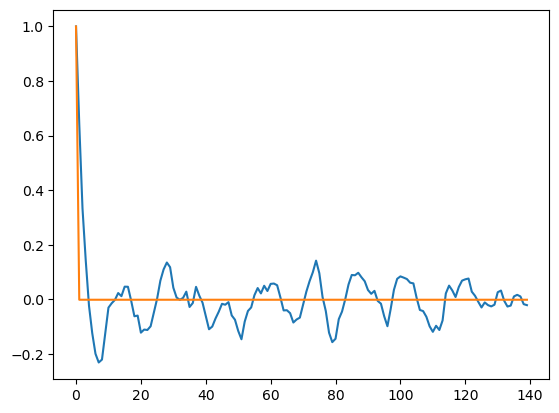

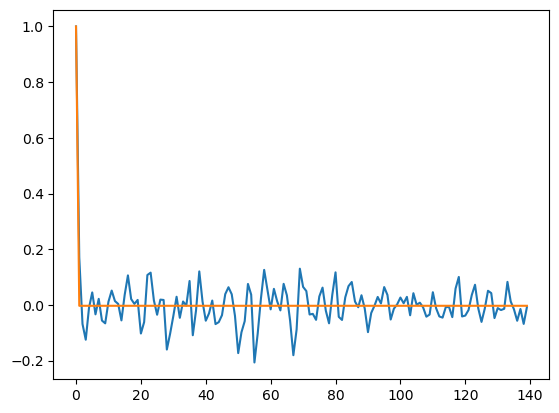

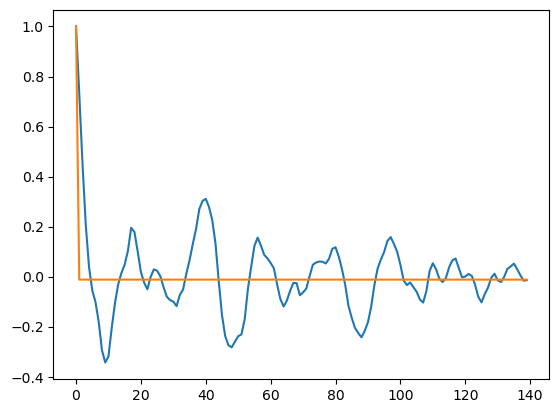

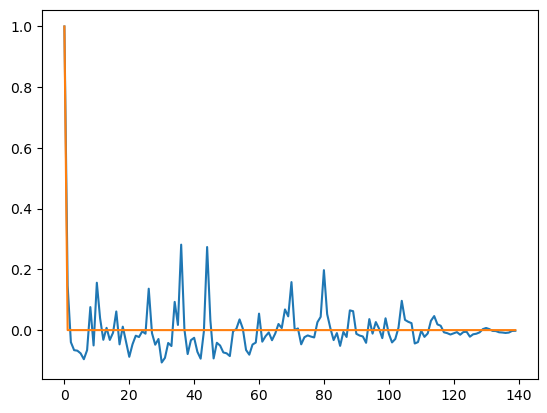

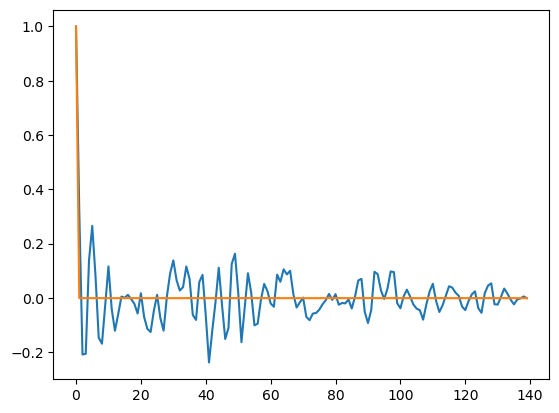

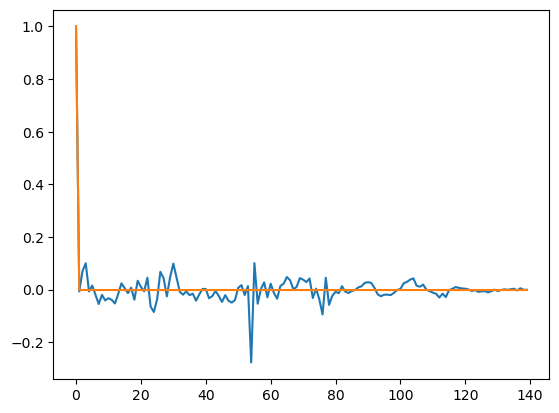

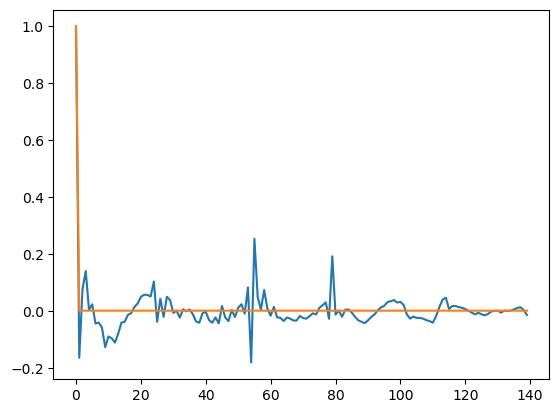

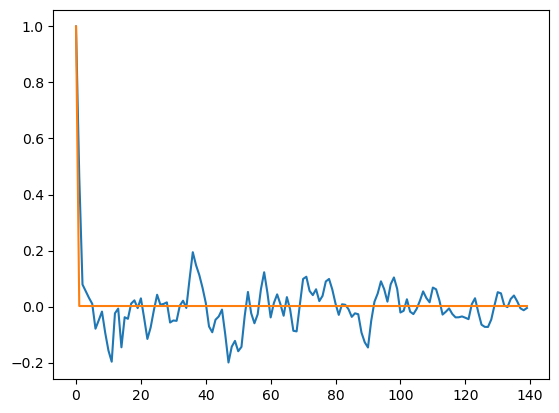

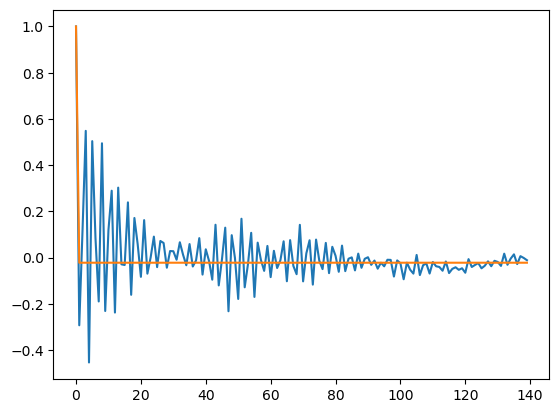

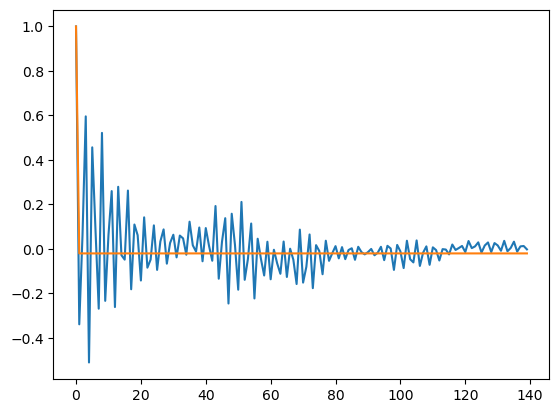

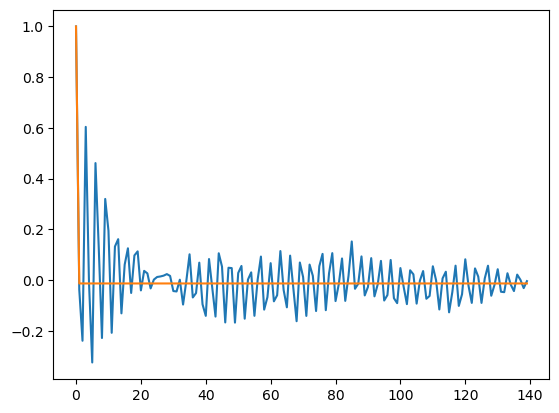

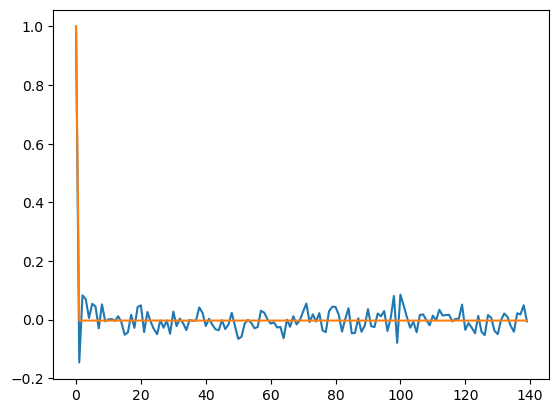

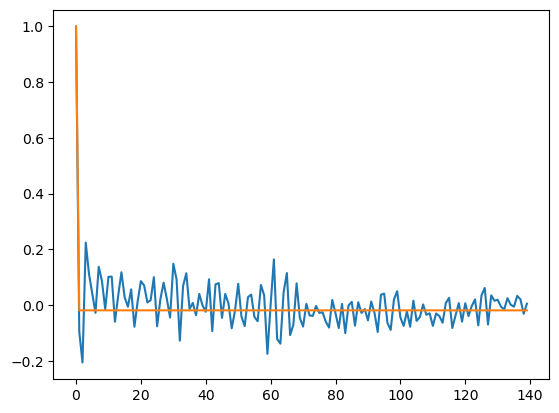

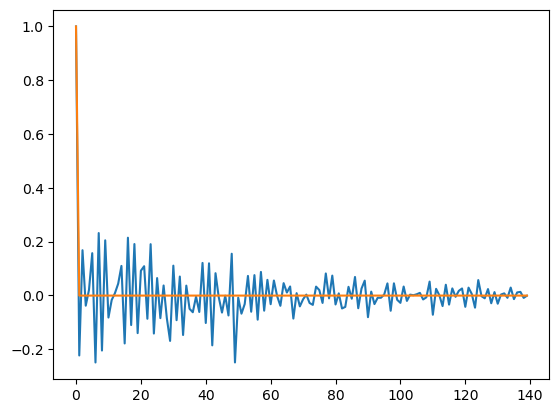

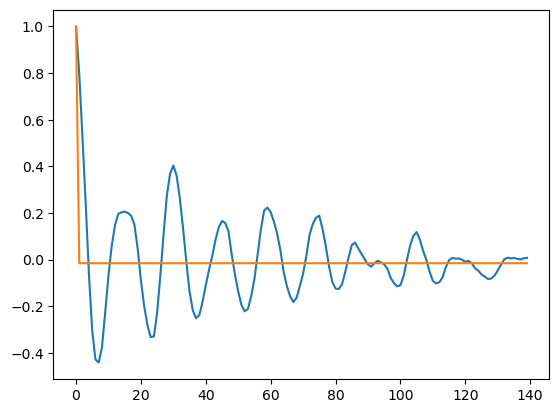

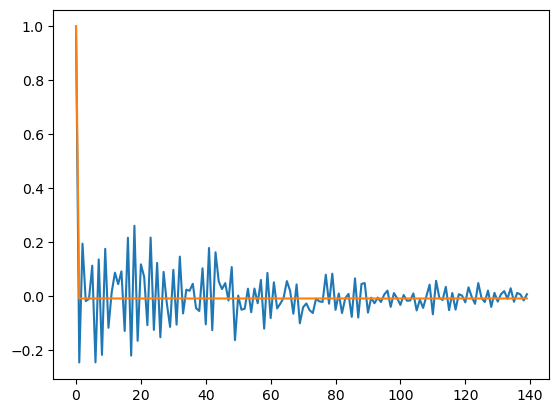

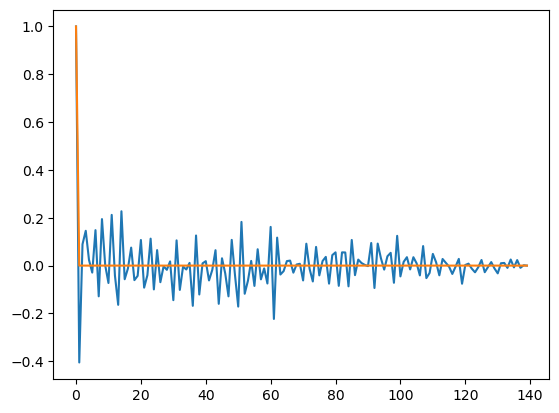

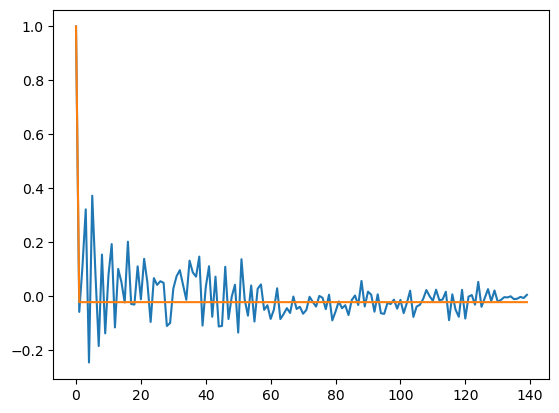

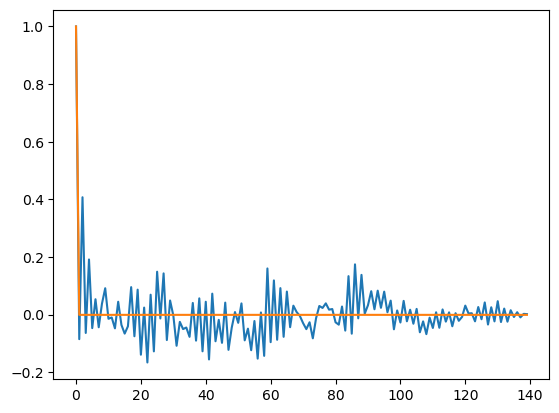

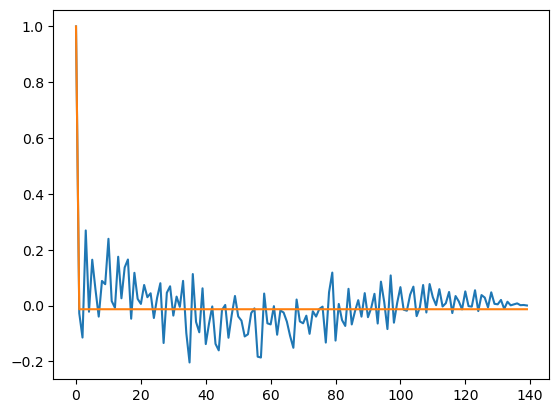

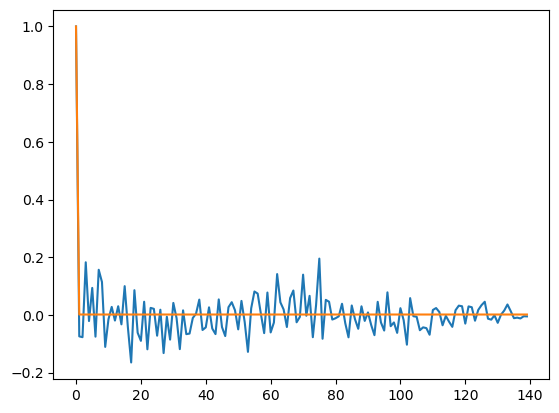

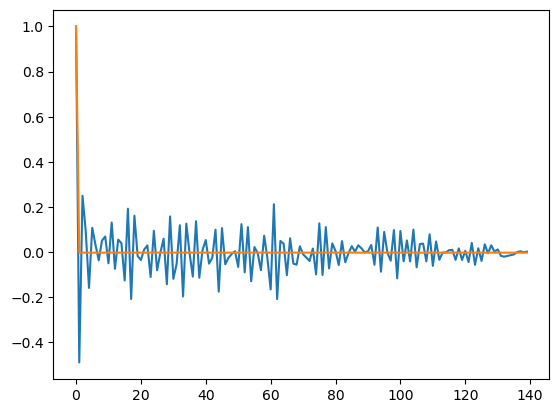

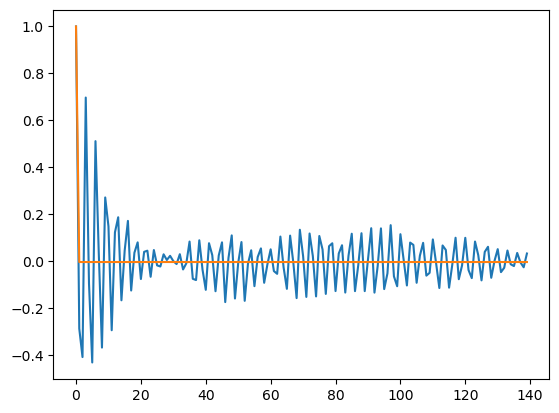

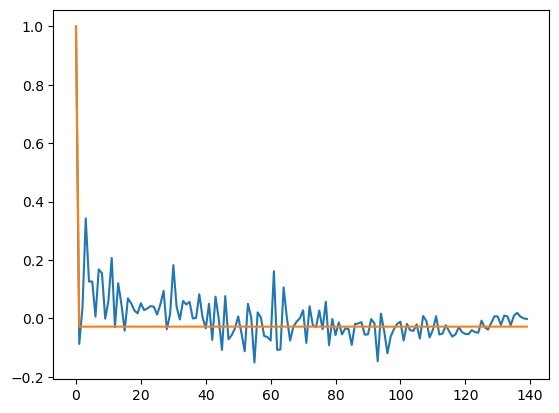

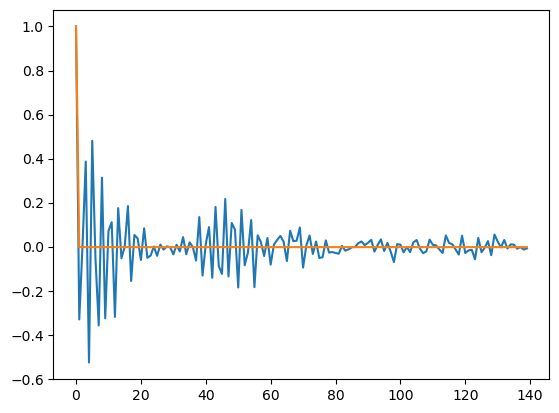

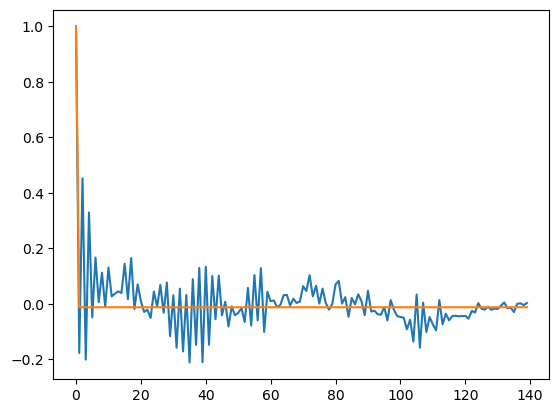

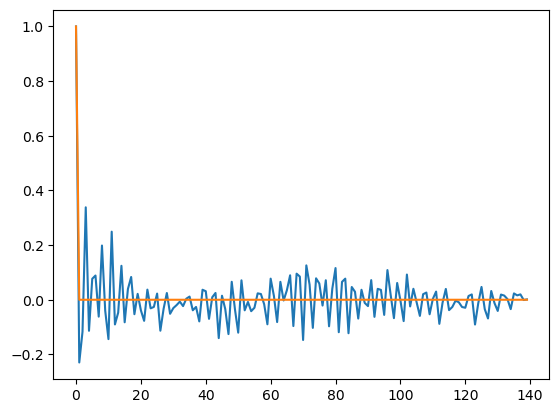

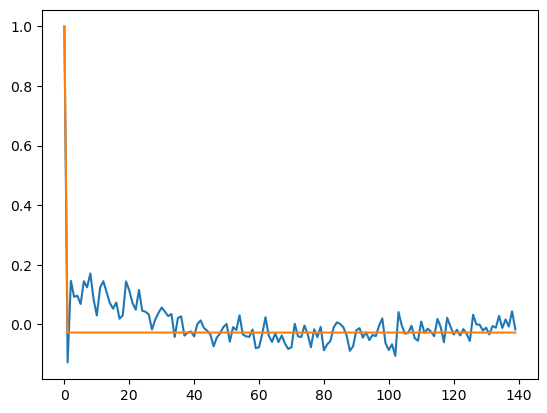

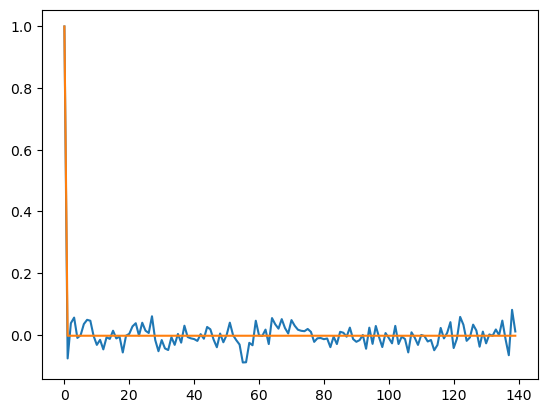

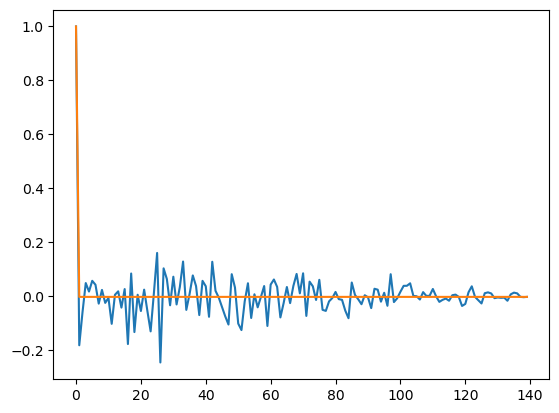

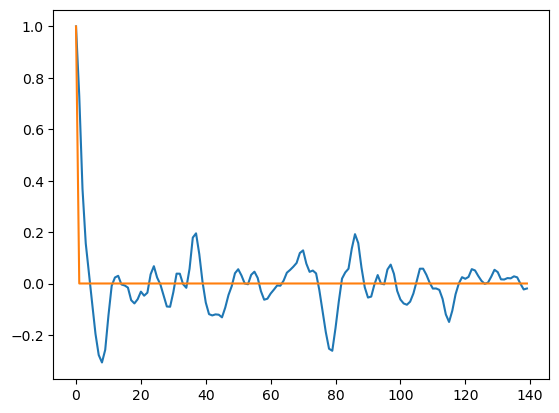

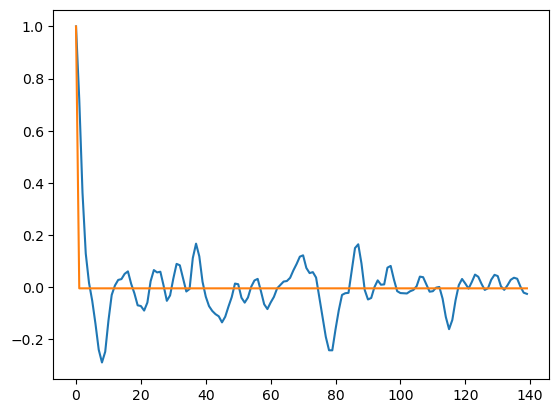

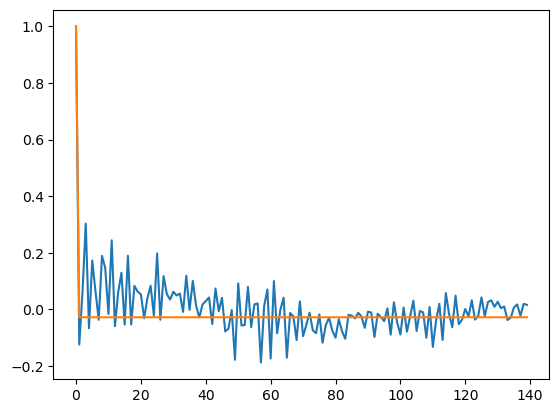

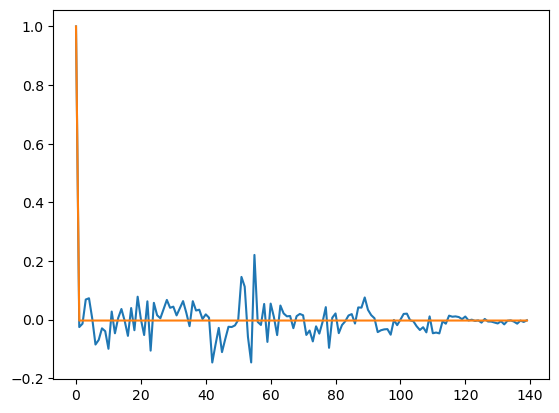

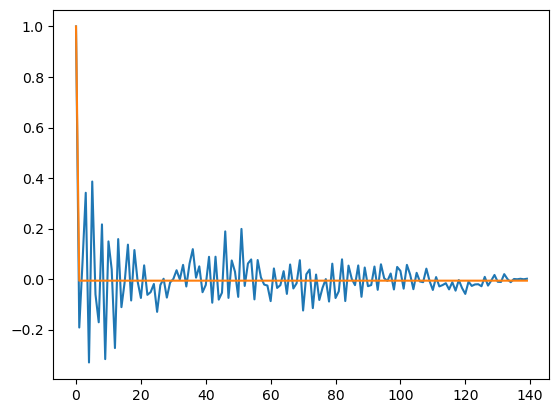

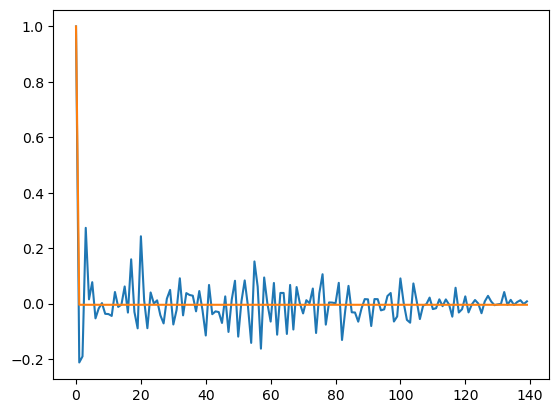

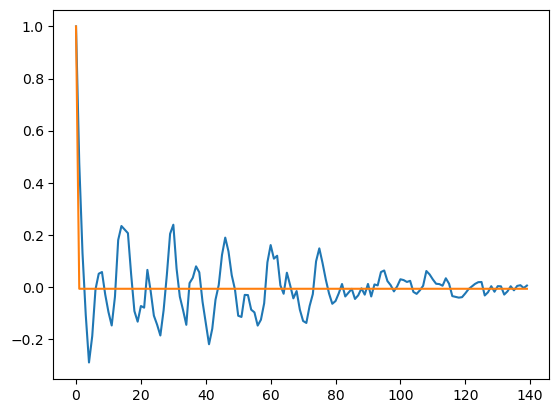

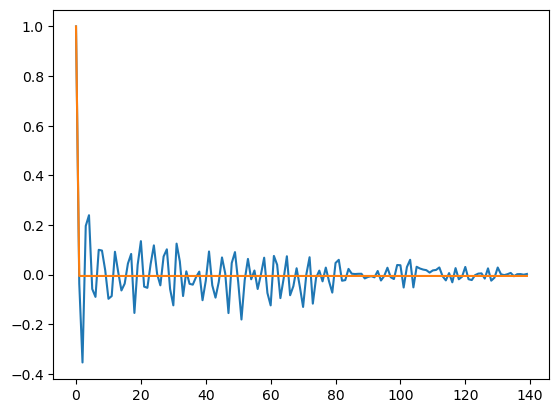

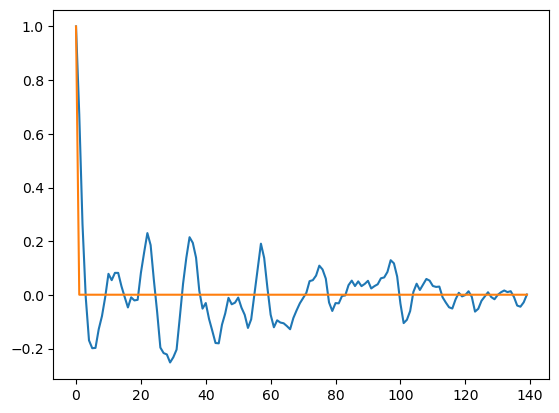

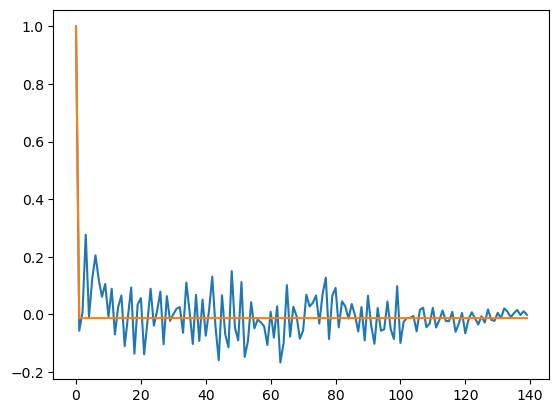

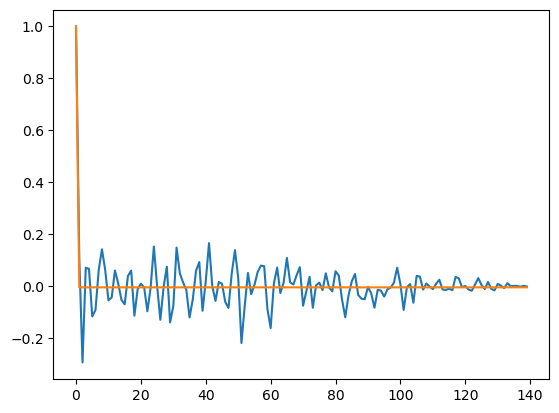

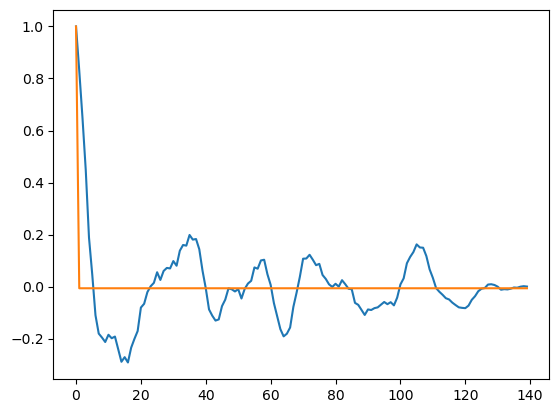

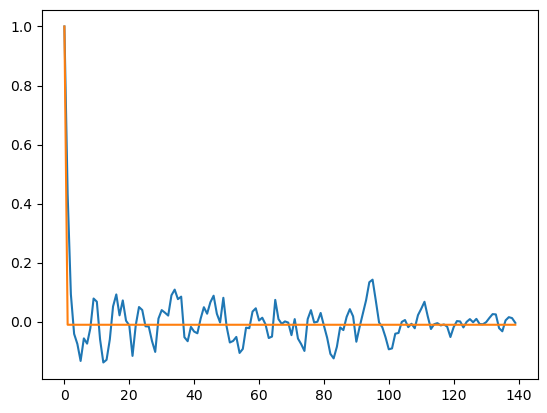

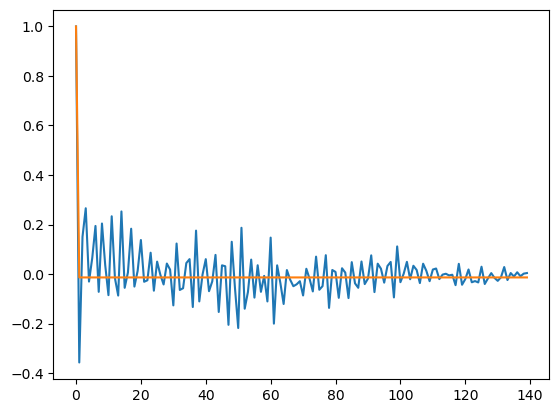

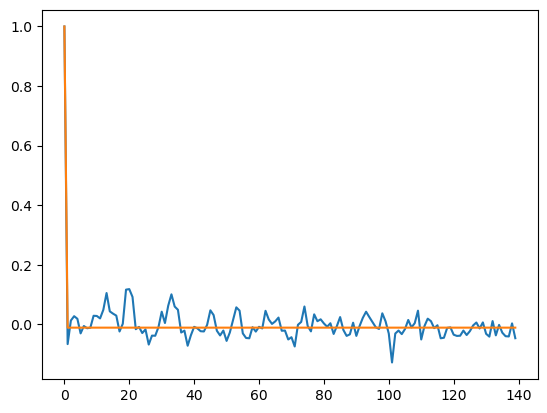

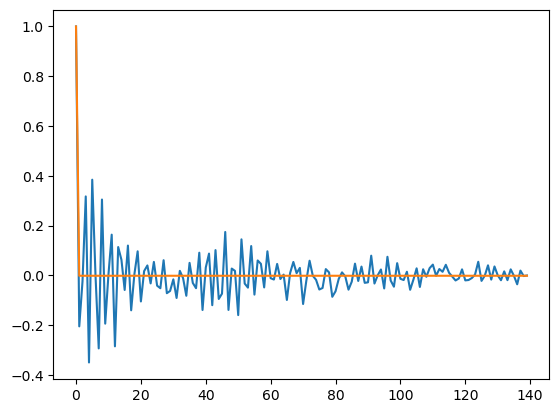

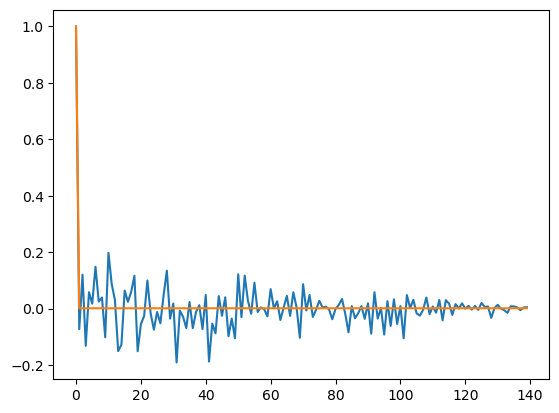

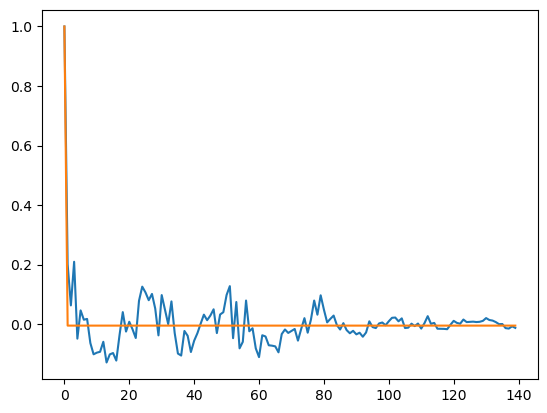

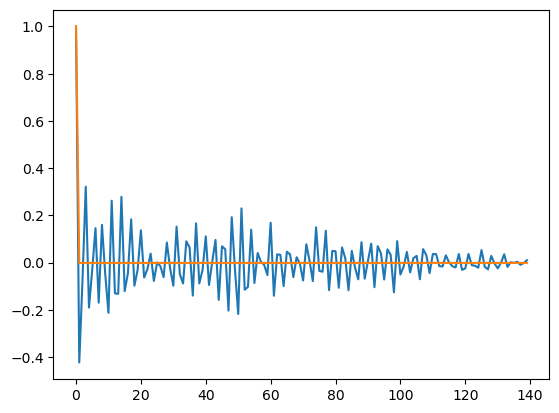

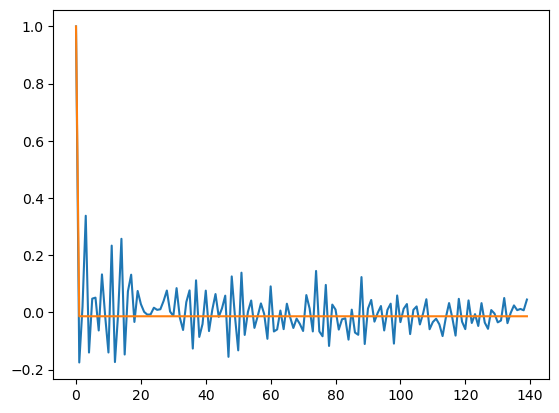

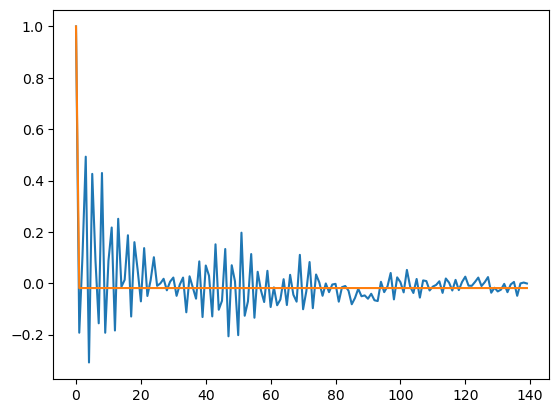

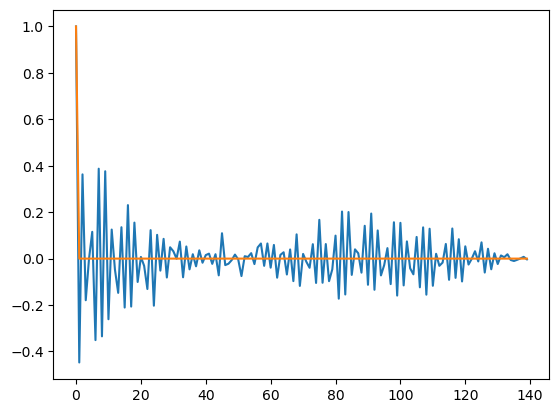

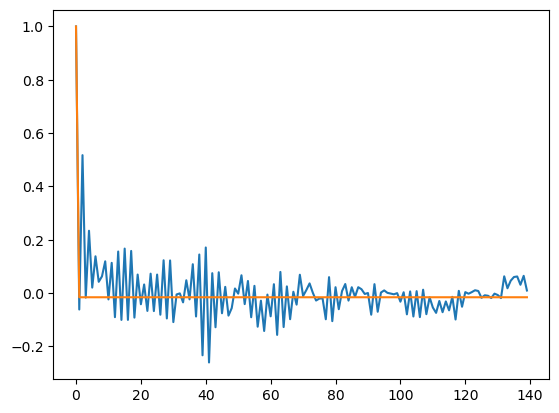

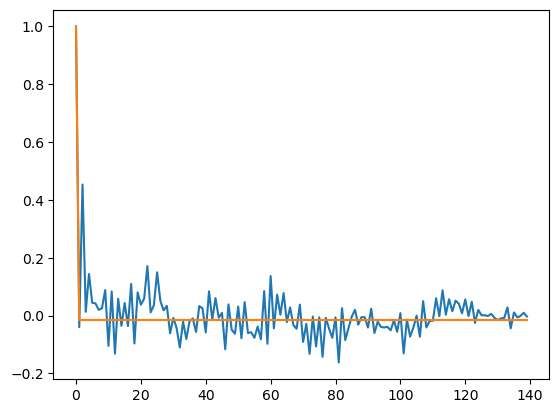

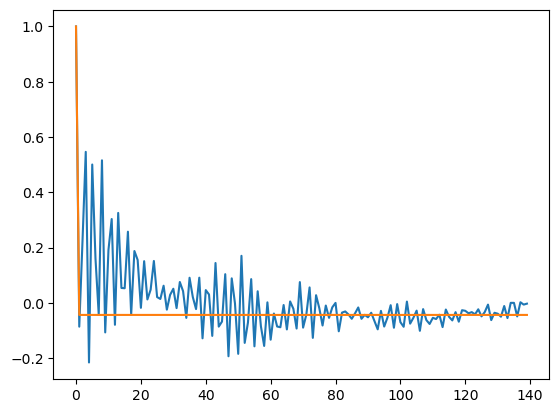

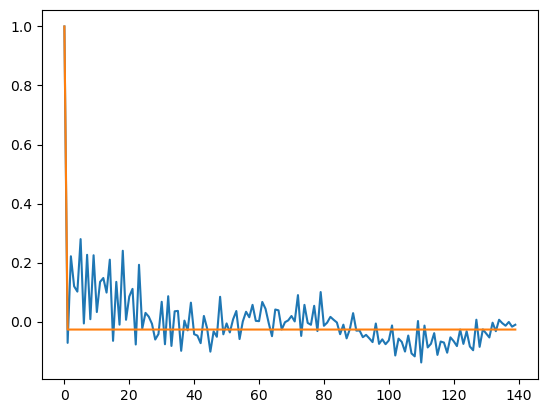

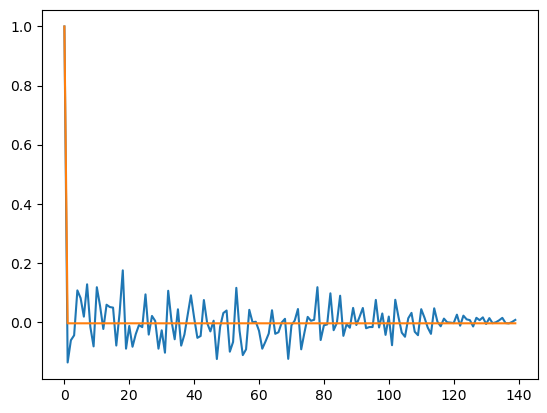

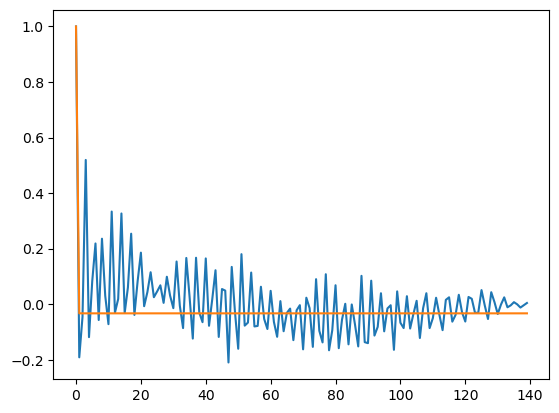

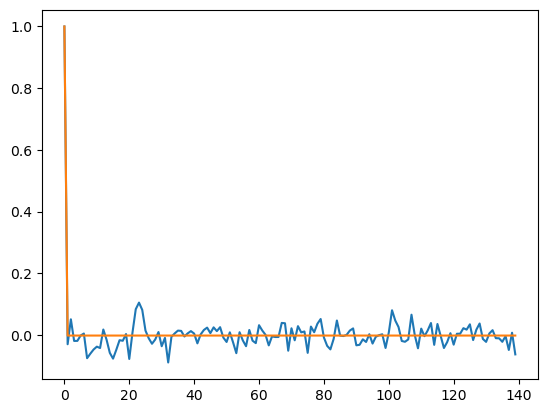

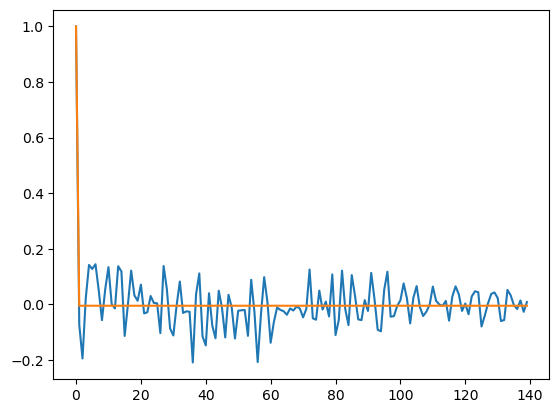

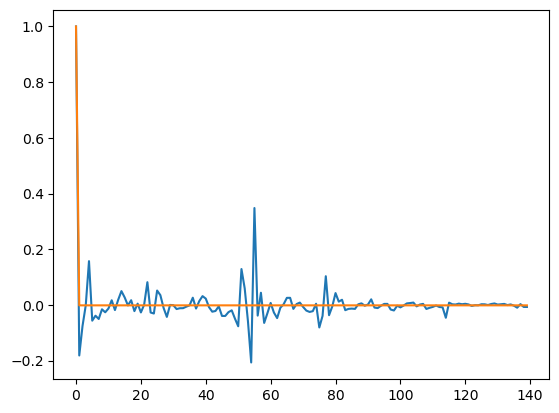

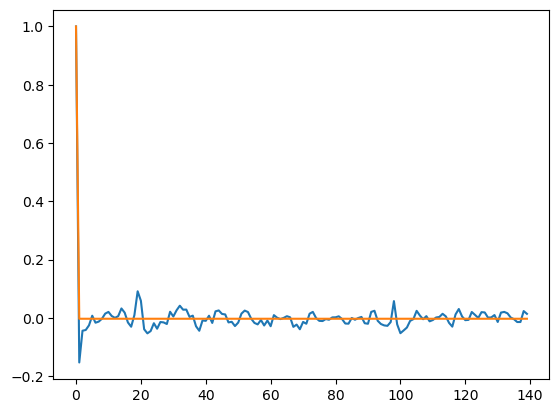

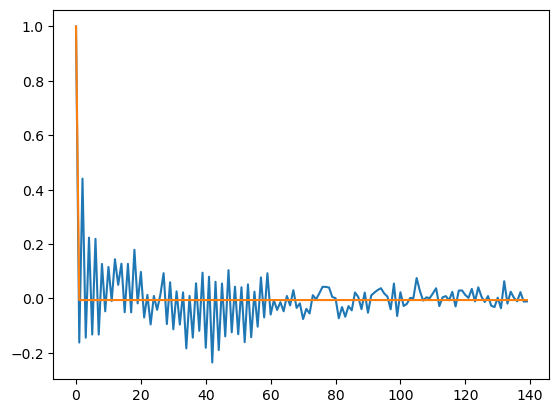

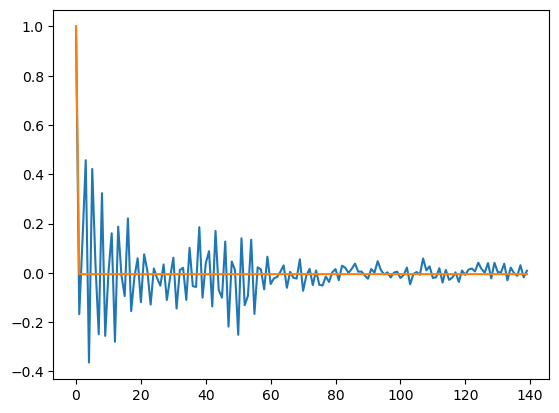

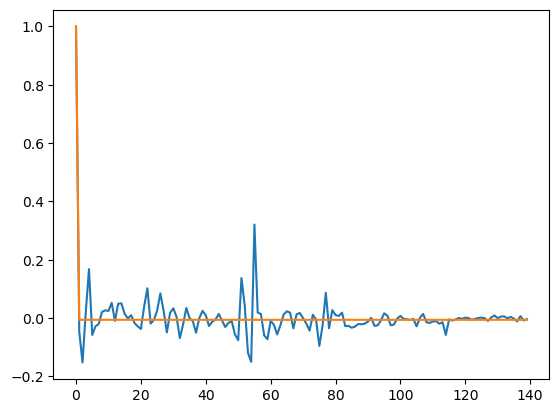

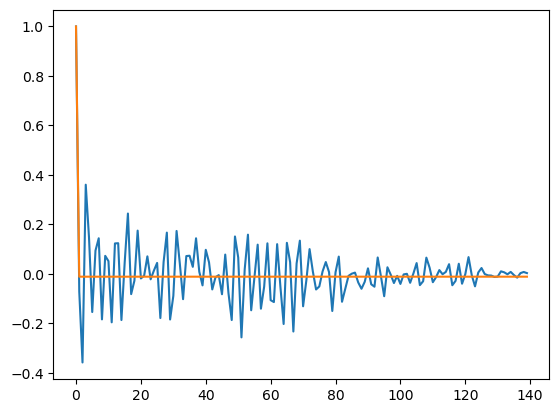

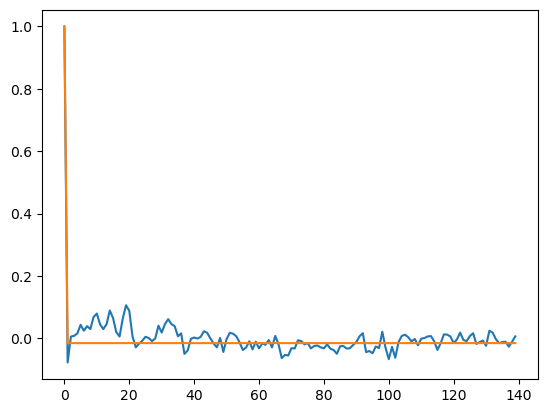

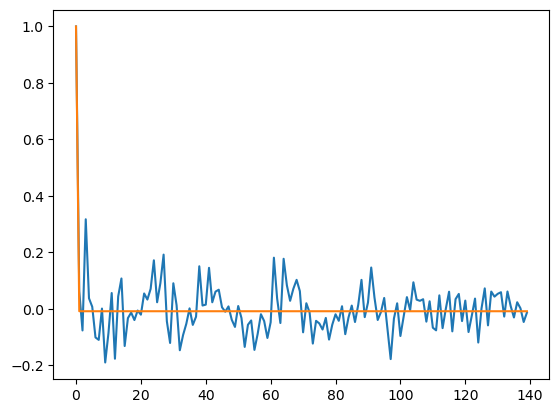

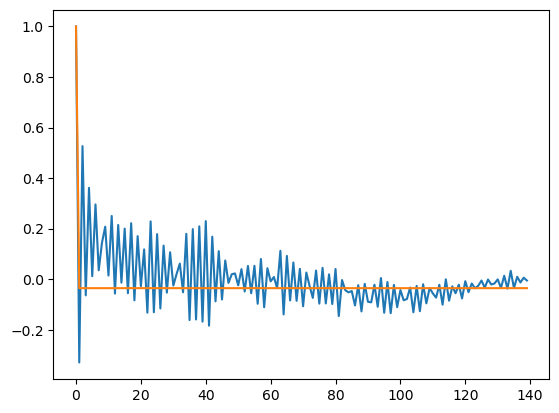

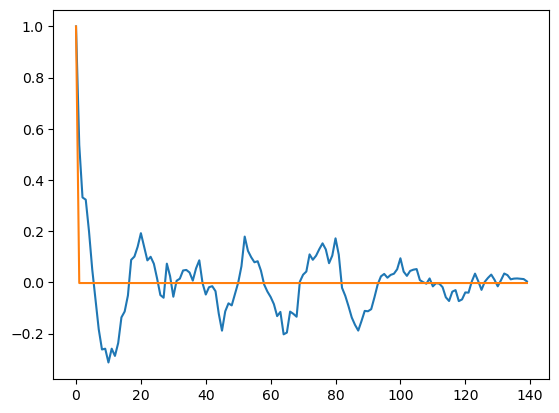

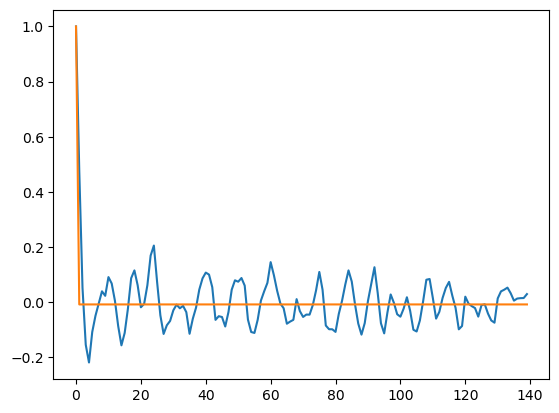

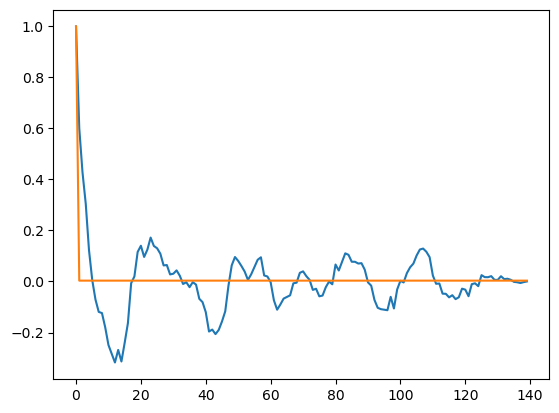

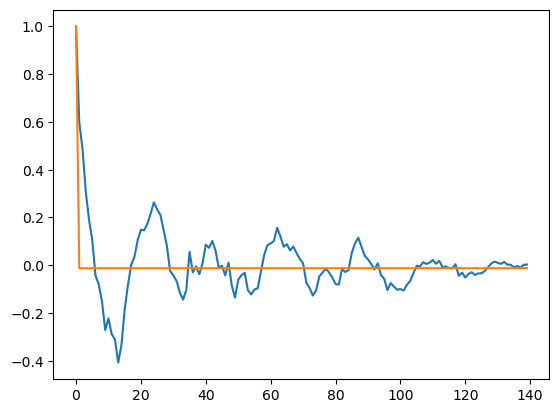

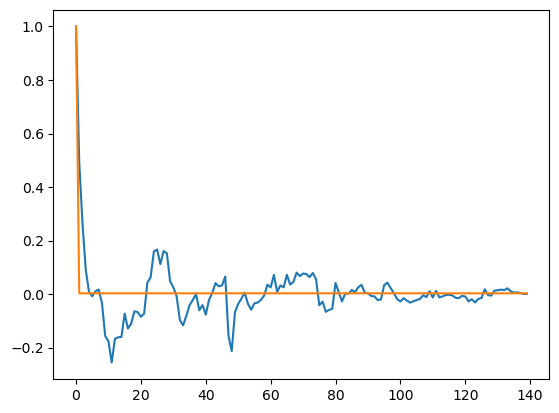

In [69]:
for i in inf_sr_inds:
    roi_idx, sub_idx = i
    plt.plot(autocorr(ts_data[sub_idx, :, roi_idx]))
    t = np.arange(len(ts_data[sub_idx, :, roi_idx]))
    tau, A, B = roi_rts[roi_idx, sub_idx, 0:3]
    plt.plot(exp_decay(t, tau, A, B))
    plt.show()

In [70]:
cnt = 0

for sub_idx in range(roi_rts.shape[1]):
    for roi_idx in range(roi_rts.shape[0]):
        if roi_rts[roi_idx][sub_idx][3] > 1.0:
            cnt += 1
            if cnt > 10:
                break
            
            plt.plot(autocorr(ts_data[sub_idx, :, roi_idx]))
            t = np.arange(len(ts_data[sub_idx, :, roi_idx]))
            tau, A, B = roi_rts[roi_idx, sub_idx, 0:3]
            plt.plot(exp_decay(t, tau, A, B))
            plt.show()

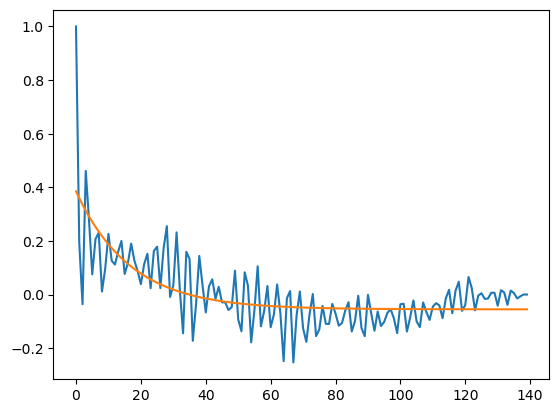

In [107]:
plot_w_fit(ts_data[sub_idx, :, roi_idx], *roi_rts[roi_idx, sub_idx, 0:3])

In [137]:
cn_roi_ts = np.array([ roi_rts_taus[i] for i in range(roi_rts_taus.shape[0]) if dloader.diag[i] == 0 ])
ad_roi_rs = np.array([ roi_rts_taus[i] for i in range(roi_rts_taus.shape[0]) if dloader.diag[i] == 1 ])

In [138]:
roi_rts_rmse = roi_rts[:, :, 3].T
roi_rts_se = roi_rts[:, :, 4].T
roi_rts_taus = roi_rts[:, :, 0].T

## Error Analysis

In [91]:
# tmp_roi_rts_mse = roi_rts_rmse

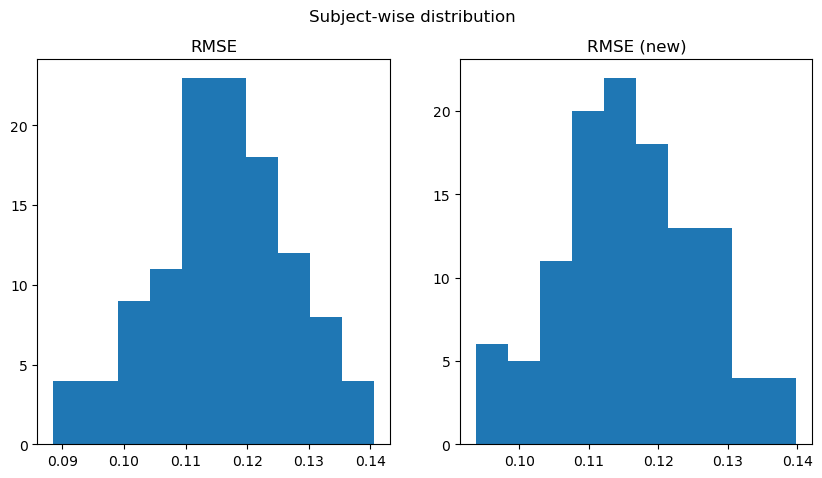

In [100]:
fig, axes = plt.subplots(ncols=2)
axes[0].hist(np.mean(roi_rts_rmse, axis=0))
axes[0].set_title('RMSE')

axes[1].hist(np.mean(tmp_roi_rts_mse, axis=0))
axes[1].set_title('RMSE (new)')

# axes[1].hist(np.mean(roi_rts_se, axis=0))
# axes[1].set_title('SE')
fig.suptitle('Subject-wise distribution')
fig.set_size_inches(10, 5)
plt.show()

9.64693832223954

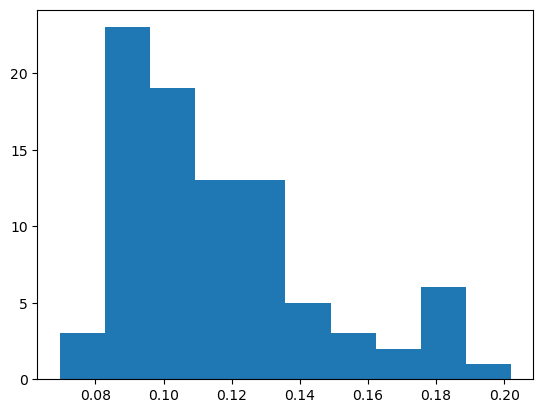

In [129]:
histout = plt.hist(np.mean(roi_rts_rmse, axis=1))
np.sum(histout[1][:-1] * histout[0])

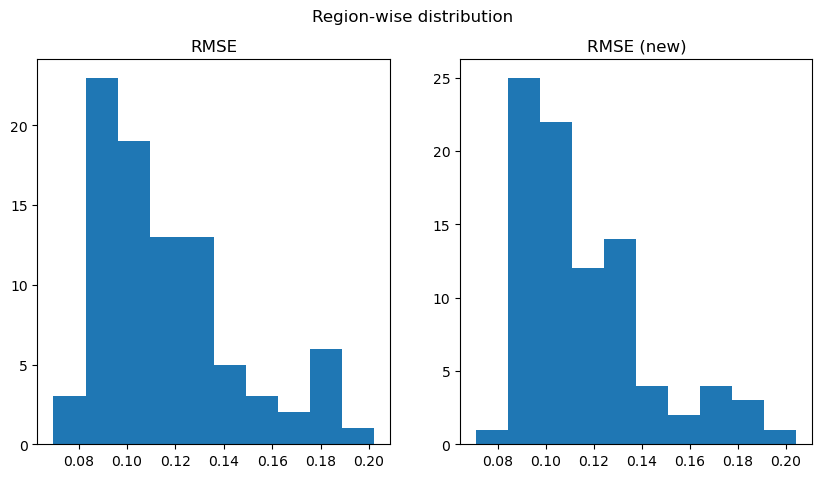

In [104]:
fig, axes = plt.subplots(ncols=2)
axes[0].hist(np.mean(roi_rts_rmse, axis=1))
axes[0].set_title('RMSE')

axes[1].hist(np.mean(tmp_roi_rts_rmse, axis=1))
axes[1].set_title('RMSE (new)')

# axes[1].hist(np.mean(roi_rts_se, axis=1))
# axes[1].set_title('SE')
fig.suptitle('Region-wise distribution')
fig.set_size_inches(10, 5)

plt.show()

In [143]:
cn_roi_rts = np.array([ roi_rts_taus[i] for i in range(roi_rts_taus.shape[0]) if dloader.diag[i] == 0 ])
ad_roi_rts = np.array([ roi_rts_taus[i] for i in range(roi_rts_taus.shape[0]) if dloader.diag[i] == 1 ])
# np.save('results/cn_roi_rts', cn_roi_rts)
# np.save('results/ad_roi_rts', ad_roi_rts)

In [140]:
# cn_roi_rts = np.load('results/cn_roi_rts.npy')
# ad_roi_rts = np.load('results/ad_roi_rts.npy')

In [144]:
print(cn_roi_rts.shape, ad_roi_rts.shape)

(54, 116) (34, 116)


In [145]:
cn_roi_rts_mean = np.mean(cn_roi_rts, axis=0)
ad_roi_rts_mean = np.mean(ad_roi_rts, axis=0)

##  P-Test

In [150]:
import scipy.stats as stats
t_stat, p_value = stats.ttest_ind(cn_roi_rts, ad_roi_rts)

# Print the results
print("t-statistic: ", t_stat.shape)
print("p-value: ", p_value.shape)

t-statistic:  (116,)
p-value:  (116,)


In [151]:
p_value

array([0.29375818, 0.14605086, 0.56357494, 0.91131824, 0.34842822,
       0.81002913, 0.84461107, 0.66992011, 0.78421242, 0.42136335,
       0.53989288, 0.70188141, 0.31389423, 0.28481357, 0.45871154,
       0.72885106, 0.46479938, 0.95963409, 0.97058471, 0.04903814,
       0.54272128, 0.93649207, 0.88959583, 0.98703188, 0.8246669 ,
       0.83815708, 0.72471552, 0.5199507 , 0.18485144, 0.27087633,
       0.64104644, 0.81905468, 0.34271043, 0.27329338, 0.70456907,
       0.53176681, 0.19763606, 0.40807728, 0.27701444, 0.58257772,
       0.13183327, 0.38437109, 0.5826766 , 0.57294288, 0.76010905,
       0.89325501, 0.76277413, 0.65611328, 0.40486421, 0.81564596,
       0.98741344, 0.72525333, 0.57229687, 0.55776596, 0.24057718,
       0.39462463, 0.89376346, 0.92226089, 0.6100768 , 0.26432556,
       0.85333097, 0.5779909 , 0.55421356, 0.79632709, 0.72168674,
       0.96770383, 0.78435892, 0.64111775, 0.19862828, 0.1547986 ,
       0.62231543, 0.77543703, 0.72287249, 0.33011248, 0.53757

In [181]:
sig_rois = list(np.where(p_value<0.15)[0])
sig_rois

[1, 19, 40, 75, 77, 82, 106, 114]

In [171]:
np.where(cn_roi_rts_mean > 1e2)

(array([], dtype=int64),)

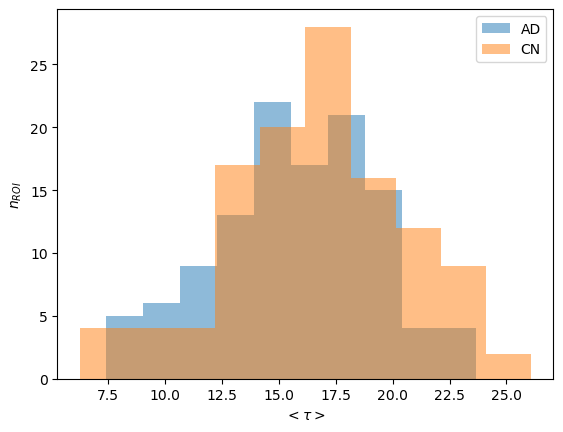

In [154]:
plt.hist(ad_roi_rts_mean, label='AD', alpha=0.5)
plt.hist(cn_roi_rts_mean, label='CN', alpha=0.5)
plt.legend()
plt.xlabel("$<\\tau>$")
plt.ylabel("$n_{ROI}$")
plt.show()

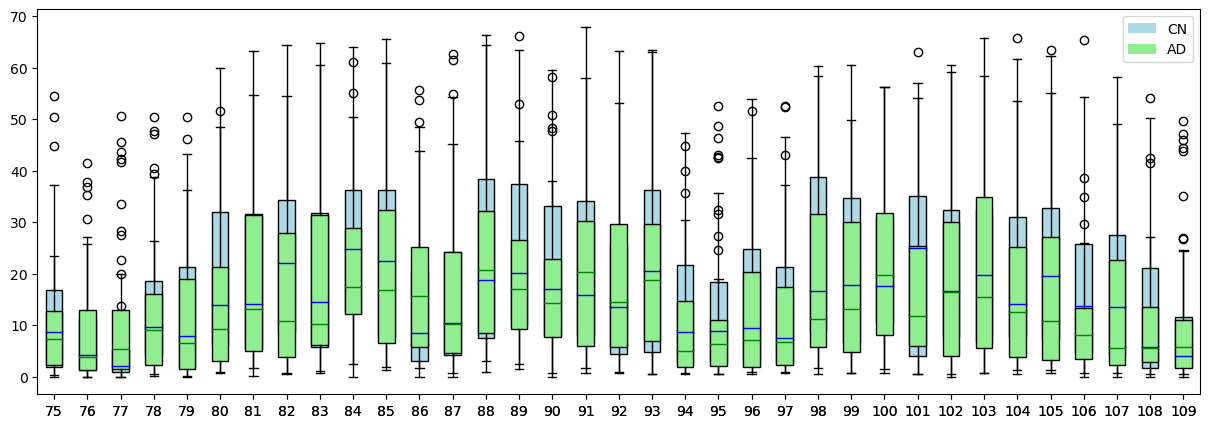

In [155]:
from matplotlib.patches import Patch

fig, ax = plt.subplots()

roi_start, roi_end = 75, 110
bp1 = ax.boxplot(cn_roi_rts[:, roi_start:roi_end], positions=range(roi_start, roi_end), patch_artist=True)
bp2 = ax.boxplot(ad_roi_rts[:, roi_start:roi_end], positions=range(roi_start, roi_end), patch_artist=True)

box_colors = ['lightblue', 'lightgreen']
median_colors = ['blue', 'green']
for bplot, box_color, median_color in zip([bp1, bp2], box_colors, median_colors):
    # change box color
    for patch in bplot['boxes']:
        patch.set_facecolor(box_color)
    # change median color
    for line in bplot['medians']:
        line.set_color(median_color)
        
color_patches = [ Patch(facecolor=box_colors[0], label=f'CN'), Patch(facecolor=box_colors[1], label=f'AD') ]
ax.legend(handles=color_patches)
fig.set_size_inches(15, 5)
# plt.show()

In [165]:
ad_roi_rts.shape

(34, 116)

In [173]:
print("Means: ", np.mean(ad_roi_rts[:, roi_idx]), np.mean(cn_roi_rts[:, roi_idx]))
print("Std: ", np.std(ad_roi_rts[:, roi_idx]), np.std(cn_roi_rts[:, roi_idx]))

Means:  16.782086090498687 22.40556378558745
Std:  15.533058303348886 16.670886253242504


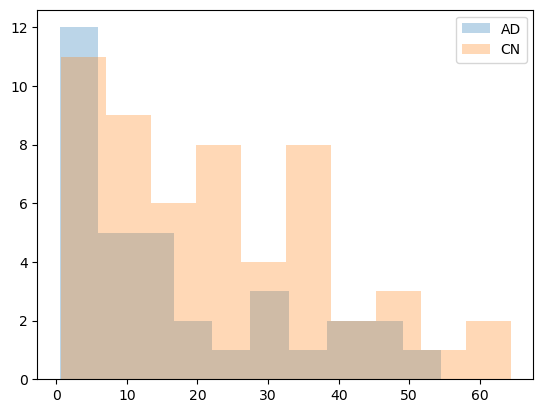

In [168]:
roi_idx = 82
plt.hist(ad_roi_rts[:, roi_idx], label='AD', alpha=0.3)
plt.hist(cn_roi_rts[:, roi_idx], label='CN', alpha=0.3)
plt.legend()
plt.show()

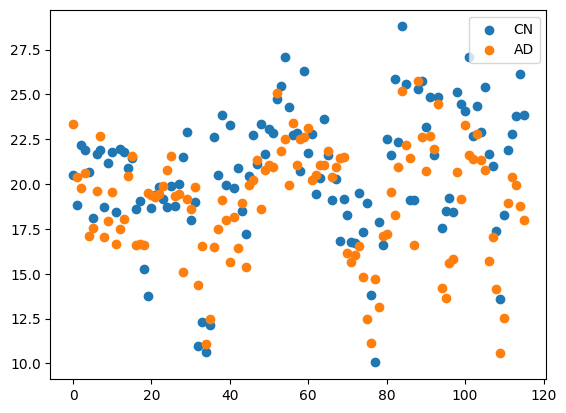

In [78]:
plt.scatter(range(len(cn_roi_rts_mean)), cn_roi_rts_mean, label='CN')
plt.scatter(range(len(ad_roi_rts_mean)), ad_roi_rts_mean, label='AD')
# plt.axhline(y=np.nanmean(cn_roi_rts_mean))
plt.legend()

### Transfer Entropy

In [183]:
import numpy as np
from scipy import stats
from scipy import ndimage



def transfer_entropy(X,Y,delay=1,gaussian_sigma=None):
	'''
	TE implementation: asymmetric statistic measuring the reduction in uncertainty
	for a future value of X given the history of X and Y. Or the amount
	of information from Y to X. Calculated through the Kullback-Leibler divergence 
	with conditional probabilities
	author: Sebastiano Bontorin
	mail: sbontorin@fbk.eu
	args:
		- X (1D array):
			time series of scalars (1D array)
		- Y (1D array):
			time series of scalars (1D array)
	kwargs:
		- delay (int): 
			step in tuple (x_n, y_n, x_(n - delay))
		- gaussian_sigma (int):
			sigma to be used
			default set at None: no gaussian filtering applied
	returns:
		- TE (float):
			transfer entropy between X and Y given the history of X
	'''

	if len(X)!=len(Y):
		raise ValueError('time series entries need to have same length')

	n = float(len(X[delay:]))

	# number of bins for X and Y using Freeman-Diaconis rule
	# histograms built with numpy.histogramdd
	binX = int( (max(X)-min(X))
				/ (2* stats.iqr(X) / (len(X)**(1.0/3))) )
	binY = int( (max(Y)-min(Y))
				/ (2* stats.iqr(Y) / (len(Y)**(1.0/3))) )

	# Definition of arrays of shape (D,N) to be transposed in histogramdd()
	x3 = np.array([X[delay:],Y[:-delay],X[:-delay]])
	x2 = np.array([X[delay:],Y[:-delay]])
	x2_delay = np.array([X[delay:],X[:-delay]])

	p3,bin_p3 = np.histogramdd(
		sample = x3.T,
		bins = [binX,binY,binX])

	p2,bin_p2 = np.histogramdd(
		sample = x2.T,
		bins=[binX,binY])

	p2delay,bin_p2delay = np.histogramdd(
		sample = x2_delay.T,
		bins=[binX,binX])

	p1,bin_p1 = np.histogramdd(
		sample = np.array(X[delay:]),
		bins=binX)

	# Hists normalized to obtain densities
	p1 = p1/n
	p2 = p2/n
	p2delay = p2delay/n
	p3 = p3/n

	# If True apply gaussian filters at given sigma to the distributions
	if gaussian_sigma is not None:
		s = gaussian_sigma
		p1 = ndimage.gaussian_filter(p1, sigma=s)
		p2 = ndimage.gaussian_filter(p2, sigma=s)
		p2delay = ndimage.gaussian_filter(p2delay, sigma=s)
		p3 = ndimage.gaussian_filter(p3, sigma=s)

	# Ranges of values in time series
	Xrange = bin_p3[0][:-1]
	Yrange = bin_p3[1][:-1]
	X2range = bin_p3[2][:-1]

	# Calculating elements in TE summation
	elements = []
	for i in range(len(Xrange)):
		px = p1[i]
		for j in range(len(Yrange)):
			pxy = p2[i][j]

			for k in range(len(X2range)):
				pxx2 = p2delay[i][k]
				pxyx2 = p3[i][j][k]

				arg1 = float(pxy*pxx2)
				arg2 = float(pxyx2*px)

				# Corrections avoding log(0)
				if arg1 == 0.0: arg1 = float(1e-8)
				if arg2 == 0.0: arg2 = float(1e-8)

				term = pxyx2*np.log2(arg2) - pxyx2*np.log2(arg1) 
				elements.append(term)

	# Transfer Entropy
	TE = np.sum(elements)
	return TE


In [185]:
cn_ts = np.array([ ts_data[i] for i in range(ts_data.shape[0]) if dloader.diag[i] == 0 ])
ad_ts = np.array([ ts_data[i] for i in range(ts_data.shape[0]) if dloader.diag[i] == 1 ])
cn_ts_mean = np.mean(cn_ts, axis=0).T
ad_ts_mean = np.mean(ad_ts, axis=0).T

In [186]:
not_sig_rois = [i for i in range(ts_data.shape[2]) if i not in sig_rois]
print(sig_rois, not_sig_rois)
ad_ts_mean[not_sig_rois].shape
# not_sig_rois

[1, 19, 40, 75, 77, 82, 106, 114] [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 76, 78, 79, 80, 81, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 107, 108, 109, 110, 111, 112, 113, 115]


(108, 140)

In [187]:
te_map = np.zeros((len(sig_rois), len(not_sig_rois)))
te_map_t = np.zeros((len(sig_rois), len(not_sig_rois))).T
for idx in range(len(sig_rois)): 
    i = sig_rois[idx]
#     print(i)
#     for jdx in range(len(not_sig_rois)):
#         print(j)
#         j = not_sig_rois[jdx]
#         te_map[idx, jdx] = te(ad_ts_mean[i], ad_ts_mean[j], delay=1)
#     res = Parallel(n_jobs=20)(delayed(te.te_compute)(ad_ts_mean[i], ad_ts_mean[j], embedding=1) for j in not_sig_rois)
    res = Parallel(n_jobs=20)(delayed(transfer_entropy)(ad_ts_mean[i], ad_ts_mean[j], delay=1) for j in not_sig_rois)
    te_map[idx] = res
    
for idx in range(len(not_sig_rois)): 
    i = not_sig_rois[idx]
    res = Parallel(n_jobs=20)(delayed(transfer_entropy)(ad_ts_mean[i], ad_ts_mean[j], delay=1) for j in sig_rois)
    te_map_t[idx] = res

In [188]:
_te_map = np.zeros((len(sig_rois), len(not_sig_rois)))
_te_map_t = np.zeros((len(sig_rois), len(not_sig_rois))).T
for idx in range(len(sig_rois)): 
    i = sig_rois[idx]
#     print(i)
#     for jdx in range(len(not_sig_rois)):
#         print(j)
#         j = not_sig_rois[jdx]
#         te_map[idx, jdx] = te(ad_ts_mean[i], ad_ts_mean[j], delay=1)
#     res = Parallel(n_jobs=20)(delayed(te.te_compute)(ad_ts_mean[i], ad_ts_mean[j], embedding=1) for j in not_sig_rois)
    res = Parallel(n_jobs=20)(delayed(transfer_entropy)(cn_ts_mean[i], cn_ts_mean[j], delay=1) for j in not_sig_rois)
    _te_map[idx] = res
    
for idx in range(len(not_sig_rois)): 
    i = not_sig_rois[idx]
    res = Parallel(n_jobs=20)(delayed(transfer_entropy)(cn_ts_mean[i], cn_ts_mean[j], delay=1) for j in sig_rois)
    _te_map_t[idx] = res

In [203]:
sig_rois

[1, 19, 40, 75, 77, 82, 106, 114]

In [206]:
p_value[106]

0.03981294629064214

Text(0.5, 1.0, 'CN')

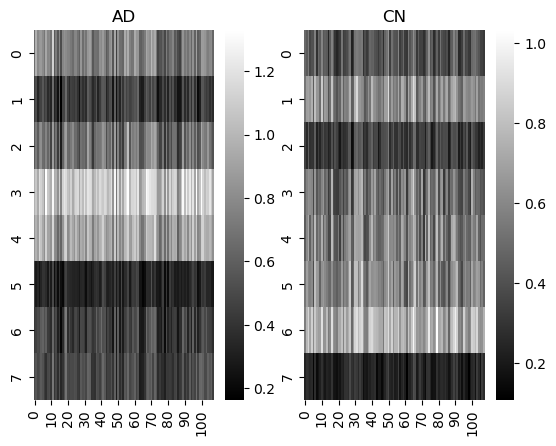

In [202]:
fig, axes = plt.subplots(ncols=2)

sns.heatmap(te_map, cmap='gray', ax=axes[0])
sns.heatmap(_te_map, cmap='gray', ax=axes[1])

axes[0].set_title("AD")
axes[1].set_title("CN")

<Axes: >

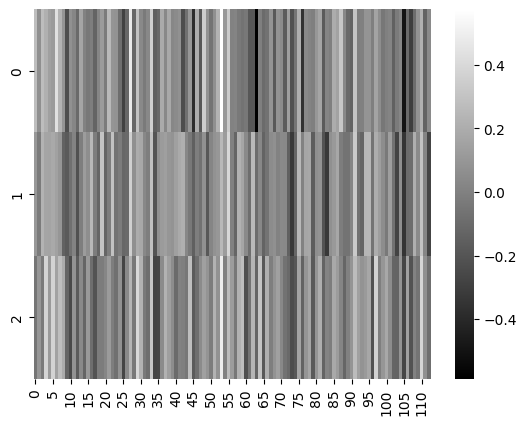

In [116]:
sns.heatmap(te_map_t.T, cmap='gray')

# FFT

In [118]:
d_max = 70
te_maps_delay = np.zeros((d_max, len(sig_rois), len(not_sig_rois)))
te_maps_t_delay = np.zeros((d_max, len(not_sig_rois), len(sig_rois)))
for d in range(1, d_max+1):
    print('d:', d)
    te_map = np.zeros((len(sig_rois), len(not_sig_rois)))
    te_map_t = np.zeros((len(sig_rois), len(not_sig_rois))).T
    for idx in range(len(not_sig_rois)): 
        i = not_sig_rois[idx]
        res = Parallel(n_jobs=20)(delayed(te.te_compute)(ad_ts_mean[i], ad_ts_mean[j], embedding=d) for j in sig_rois)
        te_map_t[idx] = res
    te_maps_t_delay[d-1] = te_map_t
    for idx in range(len(sig_rois)): 
        i = sig_rois[idx]
        res = Parallel(n_jobs=20)(delayed(te.te_compute)(ad_ts_mean[i], ad_ts_mean[j], embedding=d) for j in not_sig_rois)
        te_map[idx] = res
    te_maps_delay[d-1] = te_map


d: 1


/scratch/shivansh.seth/preproc/lib/python3.10/site-packages/numba/core/decorators.py:253: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/scratch/shivansh.seth/preproc/lib/python3.10/site-packages/numba/core/decorators.py:253: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/scratch/shivansh.seth/preproc/lib/python3.10/site-packages/numba/core/decorators.py:253: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/scratch/shivansh.seth/preproc/lib/python3.10/site-packages/numba/core/decorators.py:253: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/scratch/shivansh.seth/preproc/lib/python3.10/site-packages/numba/core/decorators.py:253: RuntimeWarning: nopython i

d: 2
d: 3
d: 4
d: 5
d: 6
d: 7
d: 8
d: 9
d: 10
d: 11
d: 12
d: 13
d: 14
d: 15
d: 16
d: 17
d: 18
d: 19
d: 20
d: 21
d: 22
d: 23
d: 24
d: 25
d: 26
d: 27
d: 28
d: 29
d: 30
d: 31
d: 32
d: 33
d: 34
d: 35
d: 36
d: 37
d: 38
d: 39
d: 40
d: 41
d: 42
d: 43
d: 44
d: 45
d: 46
d: 47
d: 48
d: 49
d: 50
d: 51
d: 52
d: 53
d: 54
d: 55
d: 56
d: 57
d: 58
d: 59
d: 60
d: 61
d: 62
d: 63
d: 64
d: 65
d: 66
d: 67
d: 68
d: 69
d: 70


ValueError: cannot call `vectorize` on size 0 inputs unless `otypes` is set

In [122]:
te_maps_delay = te_maps_delay[:d_max]
te_maps_t_delay = te_maps_t_delay[:d_max]

NameError: name 'd_max' is not defined

In [138]:
np.save('results/te_maps_delay', te_maps_delay)
np.save('results/te_maps_t_delay', te_maps_t_delay)


In [140]:
te_maps_delay = np.load('results/te_maps_delay.npy')
te_maps_t_delay = np.load('results/te_maps_t_delay.npy')

(70, 3, 113) (120, 113, 3)


In [126]:
fft_data = np.fft.fftn(te_maps_delay)

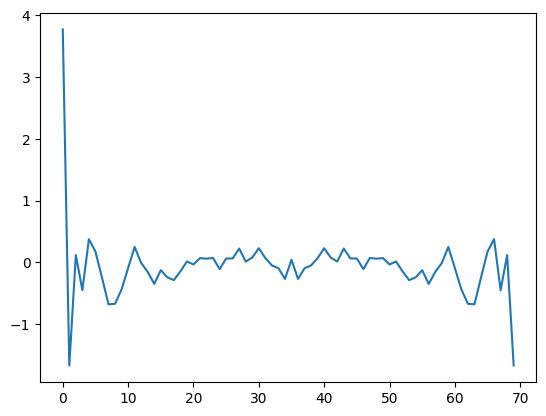

In [135]:
fft_data_mean = np.mean(fft_data.reshape(70, -1), axis=1)
plt.plot(np.real(fft_data_mean))